In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

colors = ['#fc8d59', '#4575b4',  '#d73027', '#91bfdb']

def filter_df(df, cols, filters):
    for col, filt in zip(cols, filters):
        df = df[[i in filt for i in df[col]]]
    return df

In [2]:
# Import data
data_path = '/Users/lukecullen/PycharmProjects/petrochemical-data/data/'

output_path = '/Users/lukecullen/Library/CloudStorage/OneDrive-UniversityofCambridge/CTHRU/Paper 1 - Emissions in the Petrochemical Industry/revision 1/figures/'

In [3]:
# Load in three scenarios from IEU
bau_scenario = pd.read_parquet(data_path+'scenarios/ieu_bau.parquet')
policy_scenario_non = pd.read_parquet(data_path+'scenarios/ieu_ps.parquet')
policy_scenario_bio = pd.read_parquet(data_path+'scenarios/ieu_ps_bio.parquet')
sustainable_scenario_non = pd.read_parquet(data_path+'scenarios/ieu_ss.parquet')
sustainable_scenario_bio = pd.read_parquet(data_path+'scenarios/ieu_ss_bio.parquet')

In [4]:
# Filter dfs
bau_scenario = filter_df(bau_scenario, ['Type', 'Gas'], [['Direct Process', 'Indirect Utilities', 'Direct Utilities', 'Feedstock'], ['CO2e_100a']])
policy_scenario_non = filter_df(policy_scenario_non, ['Type', 'Gas'], [['Direct Process', 'Indirect Utilities', 'Direct Utilities', 'Feedstock'], ['CO2e_100a']])
policy_scenario_bio = filter_df(policy_scenario_bio, ['Type', 'Gas'], [['Direct Process', 'Indirect Utilities', 'Direct Utilities', 'Feedstock'], ['CO2e_100a']])
sustainable_scenario_non = filter_df(sustainable_scenario_non, ['Type', 'Gas'], [['Direct Process', 'Indirect Utilities', 'Direct Utilities', 'Feedstock', 'Electricity'], ['CO2e_100a']])
sustainable_scenario_bio = filter_df(sustainable_scenario_bio, ['Type', 'Gas'], [['Direct Process', 'Indirect Utilities', 'Direct Utilities', 'Feedstock', 'Electricity'], ['CO2e_100a']])

In [5]:
# Add in CCS for DEU and DP
deu_pol = filter_df(pd.read_csv(data_path+'scenarios/dp_ccs_emissions_scurve_Direct Utilities_45.csv', low_memory=False), ['Type', 'Gas'], [['Direct Process', 'Indirect Utilities', 'Direct Utilities', 'Feedstock'], ['CO2e_100a']])
deu_pol_fac = filter_df(pd.read_csv(data_path+'scenarios/dp_ccs_emissions_facilities_Direct Utilities_45.csv', low_memory=False), ['Type', 'Gas'], [['Direct Process', 'Indirect Utilities', 'Direct Utilities', 'Feedstock'], ['CO2e_100a']])

deu_sus = filter_df(pd.read_csv(data_path+'scenarios/dp_ccs_emissions_scurve_Direct Utilities_9.csv', low_memory=False), ['Type', 'Gas'], [['Direct Process', 'Indirect Utilities', 'Direct Utilities', 'Feedstock'], ['CO2e_100a']])
deu_sus_fac = filter_df(pd.read_csv(data_path+'scenarios/dp_ccs_emissions_facilities_Direct Utilities_9.csv', low_memory=False), ['Type', 'Gas'], [['Direct Process', 'Indirect Utilities', 'Direct Utilities', 'Feedstock'], ['CO2e_100a']])

dp_pol = filter_df(pd.read_csv(data_path+'scenarios/dp_ccs_emissions_scurve_Direct Process_45.csv', low_memory=False), ['Type', 'Gas'], [['Direct Process', 'Indirect Utilities', 'Direct Utilities', 'Feedstock'], ['CO2e_100a']])
dp_pol_fac = filter_df(pd.read_csv(data_path+'scenarios/dp_ccs_emissions_facilities_Direct Process_45.csv', low_memory=False), ['Type', 'Gas'], [['Direct Process', 'Indirect Utilities', 'Direct Utilities', 'Feedstock'], ['CO2e_100a']])

dp_sus = filter_df(pd.read_csv(data_path+'scenarios/dp_ccs_emissions_scurve_Direct Process_9.csv', low_memory=False), ['Type', 'Gas'], [['Direct Process', 'Indirect Utilities', 'Direct Utilities', 'Feedstock'], ['CO2e_100a']])
dp_sus_fac = filter_df(pd.read_csv(data_path+'scenarios/dp_ccs_emissions_facilities_Direct Process_9.csv', low_memory=False), ['Type', 'Gas'], [['Direct Process', 'Indirect Utilities', 'Direct Utilities', 'Feedstock'], ['CO2e_100a']])

def add_ccs(df, ccs_df, ccs_process):
    without_ccs = df[df['Type'] != ccs_process]
    return pd.concat((without_ccs, ccs_df))

for ccs_dfs, ccs_process in zip([[dp_pol, dp_pol_fac, dp_sus, dp_sus_fac], [deu_pol, deu_pol_fac,deu_sus, deu_sus_fac]], ['Direct Process', 'Direct Utilities']):
    policy_scenario_non = add_ccs(policy_scenario_non, ccs_dfs[0], ccs_process)
    policy_scenario_bio = add_ccs(policy_scenario_bio, ccs_dfs[0], ccs_process)
    
    policy_scenario_non_facs = add_ccs(policy_scenario_non, ccs_dfs[1], ccs_process)
    policy_scenario_bio_facs = add_ccs(policy_scenario_bio, ccs_dfs[1], ccs_process)
    
    sustainable_scenario_non = add_ccs(sustainable_scenario_non, ccs_dfs[2], ccs_process)
    sustainable_scenario_bio = add_ccs(sustainable_scenario_bio, ccs_dfs[2], ccs_process)
    
    sustainable_scenario_non_facs = add_ccs(sustainable_scenario_non, ccs_dfs[3], ccs_process)
    sustainable_scenario_bio_facs = add_ccs(sustainable_scenario_bio, ccs_dfs[3], ccs_process)

In [6]:
years = [str(i) for i in range(1978, 2051)]
years_sigma = [year+'_sigma' for year in years]

# Penetration S-curve

start_year, end_year = 2020, 2050
future_years = [str(i) for i in range(2020, 2051)]
future_sigmas = [str(i)+'_sigma' for i in future_years]
a = 1
b = 0.35
c = 1
M = 15
y = range(0, end_year-start_year+1)

penetration = a / (1+np.exp(-b*(np.array(y)-M)))**a

In [7]:
def add_bio_facilties(non_df, bio_df, penetration, scale=1E6, bio_ratio=0.5):
    cols = list(policy_scenario_non_facs.columns[:15])#+['Region', 'Product group', 'Product type']
    #cols = ['PRODUCT', 'COUNTRY/TERRITORY', 'STATE', 'COMPANY', 'SITE', '#', 'Type']
    
    merged_scenarios = non_df.reset_index(drop=True).reset_index().merge(bio_df, on=cols, how='left').set_index('index')
    
    feedstock_non = non_df.reset_index(drop=True)[non_df.reset_index(drop=True)['Type'] == 'Feedstock'].sort_values(by='2050', ascending=False)
    
    convertible_plants = len(feedstock_non)
    
    years = [str(i) for i in range(2020, 2051)]
    years_sigma = [year+'_sigma' for year in years]
    
    resulting_emissions = merged_scenarios.copy()
    
    for num, year in enumerate(years):
        facil_numbers = int(np.floor(convertible_plants*bio_ratio*penetration[num]))
        
        transform_indices = feedstock_non.index[:facil_numbers]
        transform_facilities = feedstock_non.loc[transform_indices, cols]
        indices_in_result = resulting_emissions.reset_index().merge(transform_facilities, on=['PRODUCT', 'COUNTRY/TERRITORY', 'STATE', 'COMPANY', 'SITE', '#'], how='right')['index'].values
    
        resulting_emissions.loc[indices_in_result, year+'_x'] = resulting_emissions.loc[indices_in_result, year+'_y']
        resulting_emissions.loc[indices_in_result, year+'_sigma_x'] = resulting_emissions.loc[indices_in_result, year+'_sigma_y']
    
    resulting_emissions = resulting_emissions.drop(columns=[col for col in resulting_emissions.columns if '_y' in col])
    resulting_emissions.columns = [col.replace('_x', '') for col in resulting_emissions.columns]
    
    resulting_emissions_grouped = resulting_emissions[['Type']+years+years_sigma].groupby('Type').sum()/scale
    
    return resulting_emissions_grouped

In [8]:
scale = 1E6

bau_grouped = bau_scenario[['Type']+years+years_sigma].groupby('Type').sum()/scale

policy_bio_ratio = 0.5

policy_grouped_non = policy_scenario_non[['Type']+years+years_sigma].groupby('Type').sum()/scale
policy_grouped_bio = policy_scenario_bio[['Type']+years+years_sigma].groupby('Type').sum()/scale
policy_grouped = policy_grouped_non.copy()
policy_grouped[future_years] = policy_grouped_non[future_years]*(1-penetration*policy_bio_ratio) + policy_grouped_bio[future_years]*penetration*policy_bio_ratio
policy_grouped[future_sigmas] = policy_grouped_non[future_sigmas]*(1-penetration*policy_bio_ratio) + policy_grouped_bio[future_sigmas]*penetration*policy_bio_ratio

policy_grouped_facs = add_bio_facilties(policy_scenario_non_facs, policy_scenario_bio_facs, penetration, scale=scale, bio_ratio=policy_bio_ratio)

sustainable_bio_ratio = 1
sustainable_grouped_non = sustainable_scenario_non[['Type']+years+years_sigma].groupby('Type').sum()/scale
sustainable_grouped_bio = sustainable_scenario_bio[['Type']+years+years_sigma].groupby('Type').sum()/scale
sustainable_grouped = sustainable_grouped_non.copy()
sustainable_grouped[future_years] = sustainable_grouped_non[future_years]*(1-penetration*sustainable_bio_ratio) + sustainable_grouped_bio[future_years]*penetration*sustainable_bio_ratio
sustainable_grouped[future_sigmas] = sustainable_grouped_non[future_sigmas]*(1-penetration*sustainable_bio_ratio) + sustainable_grouped_bio[future_sigmas]*penetration*sustainable_bio_ratio

sustainable_grouped_facs = add_bio_facilties(sustainable_scenario_non_facs, sustainable_scenario_bio_facs, penetration, scale=scale, bio_ratio=sustainable_bio_ratio)


In [9]:
dr_ratio = 0.5
dr_grouped_pol = policy_grouped_facs.copy()
dr_grouped_pol[future_years] = dr_grouped_pol[future_years]*(1-penetration*dr_ratio)
dr_grouped_pol[future_sigmas] = dr_grouped_pol[future_sigmas]*(1-penetration*dr_ratio)

dr_grouped_sus = sustainable_grouped_facs.copy()
dr_grouped_sus[future_years] = dr_grouped_sus[future_years]*(1-penetration*dr_ratio)
dr_grouped_sus[future_sigmas] = dr_grouped_sus[future_sigmas]*(1-penetration*dr_ratio)

In [10]:
# Electrification scenario
# Gas energy 50 MJ/unit. Electricity 3.6/unit
# CO2e_100a gas 0.8416819511648339. CO2e_100a electricity 0.547058
# Global mean elec for sustainable scenario
elec_ratio = 1

global_elec = np.array([0.547058, 0.522430, 0.497801,0.473173,0.448545,0.423917,0.399289,0.374661,0.350033,0.325405,0.300777,0.286947,0.273117,0.259287,0.245457,0.231627,0.217797,0.203967,0.190137,0.176306,0.162476,0.154819,0.147162,0.139505,0.131849,0.124192,0.116535,0.108878,0.101221,0.093564,0.085907])
electricity_needs = (50/3.6) * (global_elec/0.8416819511648339)

electrification_grouped = sustainable_grouped_facs.copy()
non_elec = electrification_grouped.loc['Indirect Utilities'] - electrification_grouped.loc['Electricity']
non_elec[future_years] = (non_elec[future_years]*electricity_needs)*(penetration*elec_ratio) + non_elec[future_years]*(1-penetration*elec_ratio)
non_elec[future_sigmas] = (non_elec[future_sigmas]*electricity_needs)*(penetration*elec_ratio) + non_elec[future_sigmas]*(1-penetration*elec_ratio)
electrification_grouped.loc['Indirect Utilities'] = non_elec+electrification_grouped.loc['Electricity']

electrification_grouped.loc['Direct Utilities', future_years] = electrification_grouped.loc['Direct Utilities', future_years]*(1-penetration)
electrification_grouped.loc['Direct Utilities', future_sigmas] = electrification_grouped.loc['Direct Utilities', future_sigmas]*(1-penetration)

# electrification_grouped = electrification_grouped.drop('Electricity')
# sustainable_grouped = sustainable_grouped.drop('Electricity')

In [11]:
# Net-zero scenario
net_zero_grouped = sustainable_grouped_facs.copy()
global_elec = np.array([0.547058, 0.522430, 0.497801,0.473173,0.448545,0.423917,0.399289,0.374661,0.350033,0.325405,0.300777,0.286947,0.273117,0.259287,0.245457,0.231627,0.217797,0.203967,0.190137,0.176306,0.162476,0.154819,0.147162,0.139505,0.131849,0.124192,0.116535,0.108878,0.101221,0.093564,0.085907])*(1-penetration)
electricity_needs = (50/3.6) * (global_elec/0.8416819511648339)

non_elec = net_zero_grouped.loc['Indirect Utilities'] - net_zero_grouped.loc['Electricity']
non_elec[future_years] = (non_elec[future_years]*electricity_needs)*(penetration*elec_ratio) + non_elec[future_years]*(1-penetration*elec_ratio)
non_elec[future_sigmas] = (non_elec[future_sigmas]*electricity_needs)*(penetration*elec_ratio) + non_elec[future_sigmas]*(1-penetration*elec_ratio)
net_zero_grouped.loc['Electricity', future_years] = net_zero_grouped.loc['Electricity', future_years]*(1-penetration)
net_zero_grouped.loc['Electricity', future_sigmas] = net_zero_grouped.loc['Electricity', future_sigmas]*(1-penetration)
net_zero_grouped.loc['Indirect Utilities', future_years] = non_elec+net_zero_grouped.loc['Electricity', future_years]
net_zero_grouped.loc['Indirect Utilities', future_sigmas] = non_elec+net_zero_grouped.loc['Electricity', future_sigmas]

net_zero_grouped.loc['Direct Utilities', future_years] = net_zero_grouped.loc['Direct Utilities', future_years]*(1-penetration)
net_zero_grouped.loc['Direct Utilities', future_sigmas] = net_zero_grouped.loc['Direct Utilities', future_sigmas]*(1-penetration)

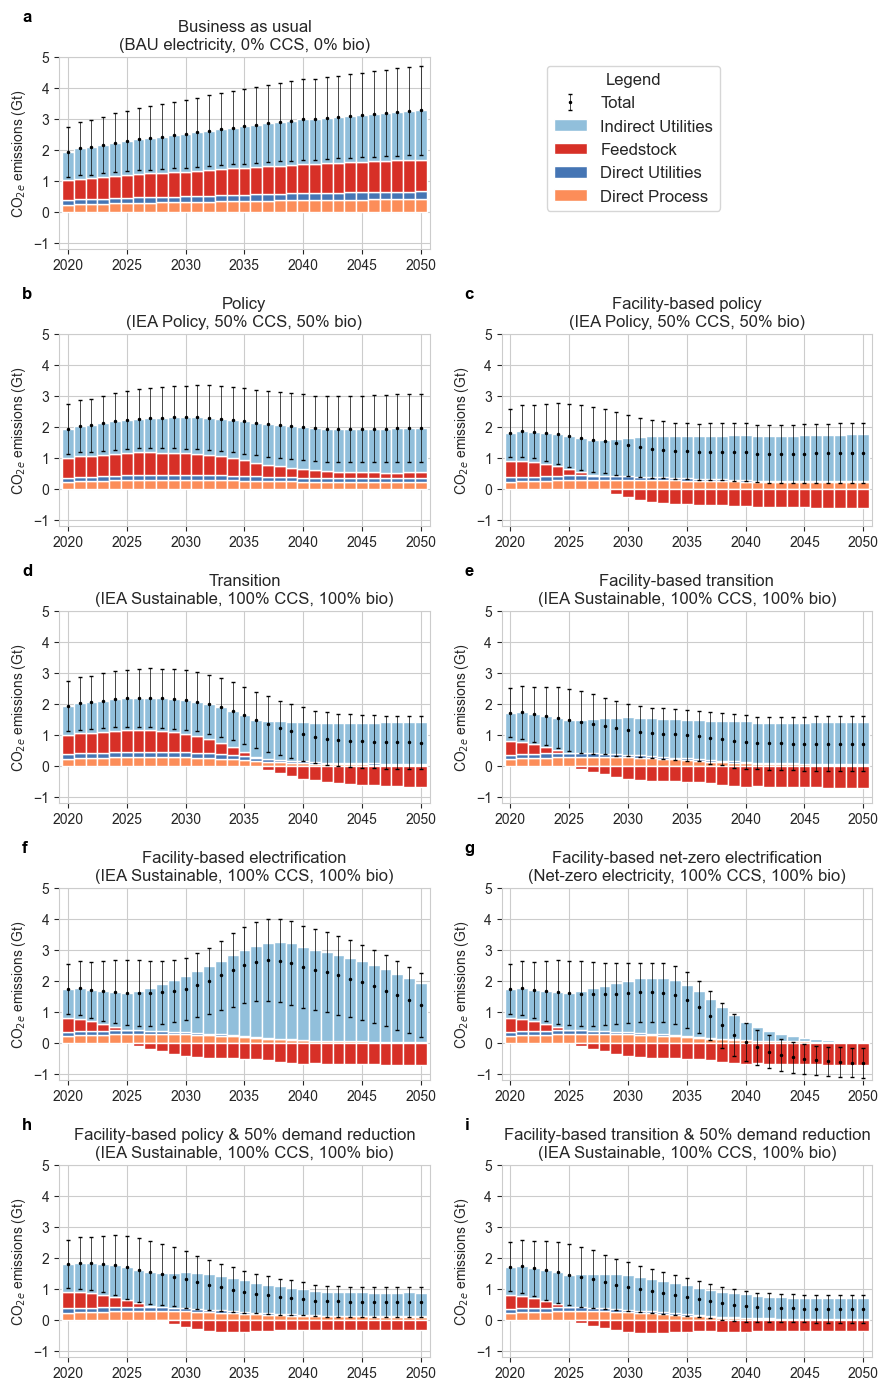

In [12]:
# Plot stacked bar plot of bau_grouped df
# Creating subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(9, 14))
axes = axes.flatten()

# gs = axes[0].get_gridspec()
# axes[0].remove()
# axes[1].remove()
# axes[0] = fig.add_subplot(gs[0, :])
bar_width = 1

future_years = [str(i) for i in range(2020, 2051)]
# Plot each DataFrame on a separate subplot
bau_grouped[future_years].transpose().plot(kind='bar', stacked=True, ax=axes[0], color=colors, title='Business as usual\n(BAU electricity, 0% CCS, 0% bio)', width=bar_width)

policy_grouped[future_years].transpose().plot(kind='bar', stacked=True, ax=axes[2], color=colors, title='Policy\n(IEA Policy, 50% CCS, 50% bio)', width=bar_width)
policy_grouped_facs[future_years].transpose().plot(kind='bar', stacked=True, ax=axes[3], color=colors, title='Facility-based policy\n(IEA Policy, 50% CCS, 50% bio)', width=bar_width)

sustainable_grouped.drop('Electricity')[future_years].transpose().plot(kind='bar', stacked=True, ax=axes[4], color=colors, title='Transition\n(IEA Sustainable, 100% CCS, 100% bio)', width=bar_width)
sustainable_grouped_facs.drop('Electricity')[future_years].transpose().plot(kind='bar', stacked=True, ax=axes[5], color=colors, title='Facility-based transition\n(IEA Sustainable, 100% CCS, 100% bio)', width=bar_width)

electrification_grouped.drop('Electricity')[future_years].transpose().plot(kind='bar', stacked=True, ax=axes[6], color=colors, title='Facility-based electrification\n(IEA Sustainable, 100% CCS, 100% bio)', width=bar_width)
net_zero_grouped.drop('Electricity')[future_years].transpose().plot(kind='bar', stacked=True, ax=axes[7], color=colors, title='Facility-based net-zero electrification\n(Net-zero electricity, 100% CCS, 100% bio)', width=bar_width)

dr_grouped_pol[future_years].transpose().plot(kind='bar', stacked=True, ax=axes[8], color=colors, title='Facility-based policy & 50% demand reduction\n(IEA Sustainable, 100% CCS, 100% bio)', width=bar_width)
dr_grouped_sus.drop('Electricity')[future_years].transpose().plot(kind='bar', stacked=True, ax=axes[9], color=colors, title='Facility-based transition & 50% demand reduction\n(IEA Sustainable, 100% CCS, 100% bio)', width=bar_width)

for num, (ax, df) in enumerate(zip(axes[[0,2,3,4,5,6,7,8,9]], [bau_grouped, policy_grouped, policy_grouped_facs, sustainable_grouped.drop('Electricity'), sustainable_grouped_facs.drop('Electricity'), electrification_grouped.drop('Electricity'), net_zero_grouped.drop('Electricity'), dr_grouped_pol, dr_grouped_sus.drop('Electricity')])):
    
    summed = df.sum()
    msize = 1.5 # if num==0 else 1.5
    ax.errorbar(future_years, summed[future_years], yerr=summed[[i+'_sigma' for i in future_years]], fmt='o', color='k', markersize=msize, ecolor='k', elinewidth=0.5, capsize=msize, label='Total')

handles, labels = axes[0].get_legend_handles_labels()
axes[1].legend(handles[-1::-1], labels[-1::-1], loc='upper left', bbox_to_anchor=(0.1, 1), title='Legend', title_fontsize='large', fontsize='large')
axes[1].axis('off')

w, h, fontsize = -0.1, 1.25, 12
# Adjustments and labels (customize as needed)
for ax, letter in zip(axes[[0,2,3,4,5,6,7,8,9]], ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']):
    ax.set_ylabel('CO$_{2e}$ emissions (Gt)')
    ax.tick_params(axis='x', rotation=0)
    # Only show every fifth year as label
    ax.set_xticks(range(0, len(future_years), 5))
    ax.set_ylim([-1.2, 5])
    # Show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.set_yticks([-1,0,1,2,3,4,5])
    ax.xaxis.set_ticks_position('bottom')
    # Remove legend
    ax.get_legend().remove()
    ax.text(w, h, letter, transform = ax.transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})



plt.tight_layout()
plt.show()

In [13]:
# Save output plot
fig.savefig(output_path+'Figure_5.eps', format='eps', bbox_inches='tight',dpi=400)

# Save output plot
fig.savefig(output_path+'Figure_5.png', format='png', bbox_inches='tight',dpi=400)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
